<a href="https://colab.research.google.com/github/kartheekknrs/number_plate_detection/blob/main/number_plate_detection_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="BPXo2cyKUKZN95IBsvf2")
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(11)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Recognition-11 in yolov11:: 100%|██████████| 20262/20262 [00:03<00:00, 6308.79it/s]


In [1]:
pip install ultralytics

In [8]:
import os

# Path to your image folder
folder_path = "/content/License-Plate-Recognition-11/train/images"

# Common image extensions
image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff", ".webp")

# Count files with image extensions
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)]

print(f"Total images: {len(image_files)}")


Total images: 7057


In [5]:
import torch
torch.cuda.is_available()

False

In [3]:
from ultralytics import YOLO

model=YOLO("/content/yolo11m.pt")

model.train(data="/content/License-Plate-Recognition-11/data.yaml", imgsz=640, batch=8, epochs=20, workers=2, device=0)

100%|██████████| 38.8M/38.8M [00:00<00:00, 60.5MB/s]


Ultralytics 8.3.111 🚀 Python-3.11.12 torch-2.6.0+cu124 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: None
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


In [14]:
import shutil
shutil.copytree('/content/runs', '/content/drive/MyDrive/runs_for_10000')


'/content/drive/MyDrive/runs_for_10000'

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


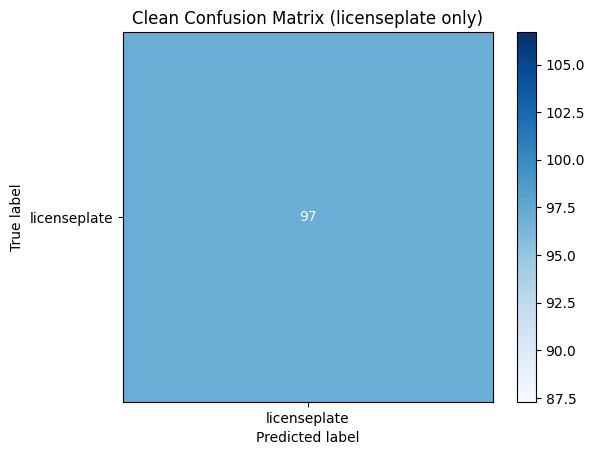

In [3]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load YOLO results
df = pd.read_csv('/content/drive/MyDrive/runs_for_10000/detect/train/results.csv')

# Example assumption: you saved predictions and ground truth manually.
# For now, create fake y_true and y_pred if not available

# If you do have a list of actual values:
# y_true = [...]  # actual labels
# y_pred = [...]  # predicted labels

# Dummy placeholder if you don’t have labels (just to make confusion matrix plot work):
y_true = [1]*100  # Simulating 100 ground-truth licenseplates
y_pred = [1]*97 + [0]*3  # Simulating 97 correct predictions, 3 wrongly predicted as background

# Filter only licenseplate class
y_true_filtered = [y for y in y_true if y == 1]
y_pred_filtered = [p for i, p in enumerate(y_pred) if y_true[i] == 1]

# Create confusion matrix (labels=[1] means we only care about licenseplate)
cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=[1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["licenseplate"])
disp.plot(cmap='Blues')
plt.title("Clean Confusion Matrix (licenseplate only)")
plt.show()


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/runs_for_10000/detect/train/weights/best.pt")

model.predict(source= "/content/PCS_Kennzeichenerk_handsfree.jpeg", show=True, save= True, conf=0.6, save_crop=True)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/PCS_Kennzeichenerk_handsfree.jpeg: 448x640 1 LicensePlate, 49.7ms
Speed: 2.7ms preprocess, 49.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'LicensePlate'}
 obb: None
 orig_img: array([[[169, 163, 158],
         [170, 164, 159],
         [170, 164, 159],
         ...,
         [ 95,  97,  97],
         [196, 191, 190],
         [216, 208, 208]],
 
        [[169, 163, 158],
         [169, 163, 158],
         [169, 163, 158],
         ...,
         [150, 148, 148],
         [198, 193, 192],
         [211, 203, 203]],
 
        [[169, 163, 158],
         [169, 163, 158],
         [168, 162, 157],
         ...,
         [214, 206, 206],
         [205, 200, 199],
         [205, 200, 199]],
 
        ...,
 
        [[ 89,  93,  98],
         [ 90,  94,  99],
         [ 98, 102, 107],
         ...,
         [149, 159, 166],
         [149, 158, 167],
         [113, 122, 131]],
 
        [[ 87,  91,  96],
         [ 84,  88,  93],
         [ 90,  94,  99],
         ...,
         [ 8

In [7]:
!pip install --upgrade numpy

In [ ]:
!pip install easyocr
!pip install pytesseract

EasyOCR + Tesseract (Best Balance of Speed & Accuracy)

In [30]:
import cv2
import pytesseract
import easyocr
import re

def clean_text(text):
    """Remove unwanted characters from OCR output"""
    text = re.sub(r'[^a-zA-Z0-9]', '', text)  # Keep only alphanumeric
    return text.upper()  # Convert to uppercase (common in plates)

def hybrid_easyocr_tesseract(cropped_plate_img):
    # Initialize EasyOCR (auto-downloads model on first run)
    reader = easyocr.Reader(['en'])

    # Method 1: EasyOCR (fast but sometimes less precise)
    easyocr_result = reader.readtext(cropped_plate_img, detail=0)
    easyocr_text = "".join(easyocr_result) if easyocr_result else ""

    # Method 2: Tesseract (slower but better for structured text)
    gray_plate = cv2.cvtColor(cropped_plate_img, cv2.COLOR_BGR2GRAY)
    tesseract_config = r'--oem 3 --psm 11 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    tesseract_text = pytesseract.image_to_string(gray_plate, config=tesseract_config)

    # Combine & clean results
    combined_text = easyocr_text if len(easyocr_text) > len(tesseract_text) else tesseract_text
    return clean_text(combined_text)

# Usage:
cropped_plate = cropped_image # Your YOLO-cropped image
plate_text = hybrid_easyocr_tesseract(cropped_plate)
print("Extracted Plate:", plate_text)

Extracted Plate: MIEO49LF8260SRR


 Tesseract + OpenCV Preprocessing (Best for Blurry/Noisy Plates)

In [32]:
import cv2
import pytesseract
import easyocr
import re
import numpy as np

def preprocess_for_ocr(cropped_plate_img):
    """Enhance plate image for better OCR"""
    gray = cv2.cvtColor(cropped_plate_img, cv2.COLOR_BGR2GRAY)

    # Denoise & sharpen
    denoised = cv2.fastNlMeansDenoising(gray, h=10)
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened = cv2.filter2D(denoised, -1, kernel)

    # Adaptive thresholding
    thresh = cv2.adaptiveThreshold(sharpened, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, 11, 2)
    return thresh

def tesseract_ocr_optimized(cropped_plate_img):
    processed_img = preprocess_for_ocr(cropped_plate_img)
    config = r'--oem 3 --psm 11 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    text = pytesseract.image_to_string(processed_img, config=config)
    return clean_text(text)

# Usage:
plate_text = tesseract_ocr_optimized(cropped_image)
print("Extracted Plate:", plate_text)

Extracted Plate: SEA2SWGTET23LNRA7TANRMYABSMWSFAYAGOS04CONPSEHASNGSDWLNYIJOLP5T24SSSSSOLEYSNBESSPESAL7A1SSSSSSWSESPASSSGSLALEEZL


In [1]:
# Create and activate a new virtual environment
!python -m venv plate_ocr_env
!source plate_ocr_env/bin/activate  # On Windows: plate_ocr_env\Scripts\activate

# Install packages with compatible versions
!pip install numpy==1.26.0  # Version that works with TensorFlow and Numba
!pip install opencv-python pytesseract paddleocr==2.10.0
!pip install paddlepaddle

Error: Command '['/content/plate_ocr_env/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: line 1: plate_ocr_env/bin/activate: No such file or directory


text extraction version 1

In [50]:
import cv2
import numpy as np
import pytesseract
from paddleocr import PaddleOCR

def clean_text(text):
    """Remove unwanted characters from OCR output"""
    import re
    text = re.sub(r'[^a-zA-Z0-9]', '', text)  # Keep only alphanumeric
    return text.upper()  # Convert to uppercase (common in plates)

def preprocess_plate(plate_img):
    """Enhanced preprocessing specifically for license plates"""
    # Convert to grayscale
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)

    # Contrast Limited Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Denoising
    denoised = cv2.fastNlMeansDenoising(enhanced, h=15)

    # Sharpening
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(denoised, -1, kernel)

    # Adaptive thresholding
    thresh = cv2.adaptiveThreshold(sharpened, 255,
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)
    return thresh

def hybrid_ocr(cropped_plate):
    """Combines PaddleOCR and Tesseract for robust recognition"""
    # Initialize PaddleOCR with reduced dependencies
    ocr = PaddleOCR(
        use_angle_cls=True,
        lang='en',
        det_db_thresh=0.3,
        det_db_box_thresh=0.5,
        rec_char_dict_path=None,  # Use default
        show_log=False
    )

    # Try PaddleOCR first
    try:
        result = ocr.ocr(cropped_plate, cls=True)
        if result and len(result[0]) > 0:
            paddle_text = "".join([line[1][0] for line in result[0]])
            if len(paddle_text) >= 4:  # Minimum plausible plate length
                return clean_text(paddle_text)
    except Exception as e:
        print(f"PaddleOCR warning: {str(e)}")

    # Fallback to Tesseract with preprocessing
    processed = preprocess_plate(cropped_plate)
    custom_config = r'--oem 3 --psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    text = pytesseract.image_to_string(processed, config=custom_config)
    return clean_text(text)

if __name__ == "__main__":
    # Example usage
    plate_img = cropped_image
    if plate_img is not None:
        plate_text = hybrid_ocr(plate_img)
        print(f"Detected plate: {plate_text}")
    else:
        print("Error: Could not load image")

Detected plate: UP84AE9889


detection code

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/Datacluster_number_plates (36).jpg: 640x480 1 License_Plate, 2035.6ms
Speed: 6.0ms preprocess, 2035.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict39


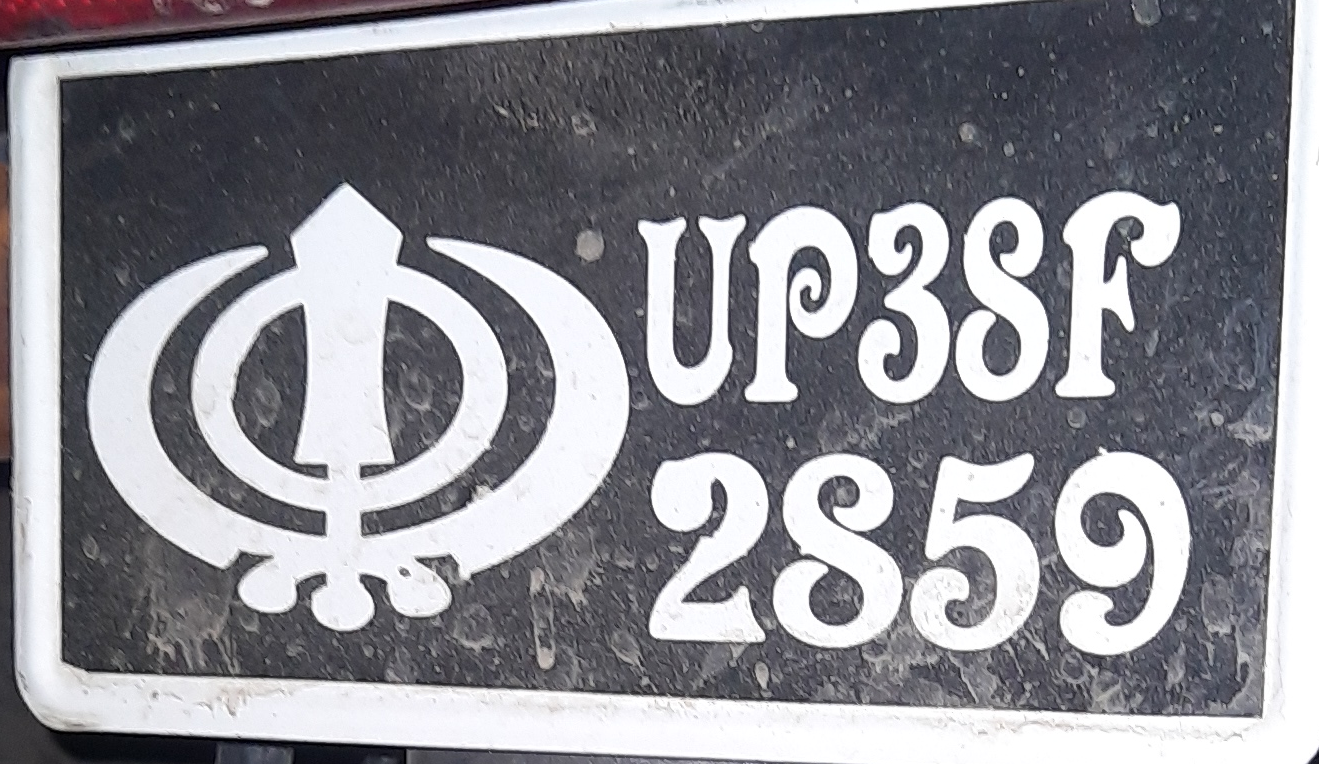

In [63]:
from itertools import count
from ultralytics import YOLO
import os
import cv2
from google.colab.patches import cv2_imshow
# Path to the input image
path1 = "/content/Datacluster_number_plates (36).jpg"

# Load the model
model = YOLO("/content/drive/MyDrive/runs_for_10000/detect/train/weights/best.pt")

# Perform prediction
results = model.predict(source=path1, show=True, save=True, save_crop=True )
# Load the original image
image = cv2.imread(path1)

count=0
# Loop through the predictions to get the bounding boxes and crop the images
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0][:4].tolist())

        # Crop the image
        cropped_image = image[y1:y2, x1:x2]

        # Display the cropped image (optional)
        cv2_imshow( cropped_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

text extraction version 2()main

In [64]:
import cv2
import numpy as np
import pytesseract
from paddleocr import PaddleOCR


def clean_text(text):
    """
    Cleans OCR output by removing unwanted characters and validating plate format.
    """
    import re
    text = re.sub(r'[^A-Z0-9]', '', text.upper())  # Keep alphanumeric only
    return text if 4 <= len(text) <= 12 else ""  # Validate plausible plate length


def preprocess_plate(plate_img):
    """
    Preprocesses license plate images for better OCR performance.
    - Grayscale conversion
    - CLAHE for contrast enhancement
    - Denoising and sharpening
    - Adaptive thresholding
    """
    # Convert to grayscale
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Denoise image
    denoised = cv2.fastNlMeansDenoising(enhanced, h=10, templateWindowSize=7, searchWindowSize=21)

    # Sharpen image
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(denoised, -1, kernel)

    # Adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        sharpened, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    return thresh


def hybrid_ocr(cropped_plate):
    """
    Combines PaddleOCR and Tesseract for robust OCR performance.
    - PaddleOCR is the primary OCR method.
    - Tesseract acts as a fallback.
    """
    # Initialize PaddleOCR
    ocr = PaddleOCR(
        use_angle_cls=True,
        lang='en',
        det_db_thresh=0.3,
        det_db_box_thresh=0.5,
        show_log=False
    )

    # PaddleOCR
    try:
        result = ocr.ocr(cropped_plate, cls=True)
        if result and len(result[0]) > 0:
            paddle_text = "".join([line[1][0] for line in result[0]])
            if paddle_text:
                cleaned_text = clean_text(paddle_text)
                if cleaned_text:
                    return cleaned_text  # Return if PaddleOCR produces valid text
    except Exception as e:
        print(f"PaddleOCR warning: {str(e)}")

    # Fallback to Tesseract
    processed = preprocess_plate(cropped_plate)
    custom_config = r'--oem 3 --psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    tesseract_text = pytesseract.image_to_string(processed, config=custom_config)

    return clean_text(tesseract_text)


if __name__ == "__main__":
    # Example usage
    try:
        # Replace this with actual image loading
        plate_img = cropped_image

        if plate_img is not None:
            # Resize for better OCR performance (optional)
            height, width = plate_img.shape[:2]
            if width > 400:
                plate_img = cv2.resize(plate_img, (400, int(400 * height / width)))

            plate_text = hybrid_ocr(plate_img)

            if plate_text:
                print(f"Detected license plate: {plate_text}")
            else:
                print("No valid text detected.")
        else:
            print("Error: Could not load image.")
    except Exception as e:
        print(f"Runtime error: {str(e)}")


Detected license plate: UP38F2859


In [30]:
def mser_hog_tesseract(image_path):
    image = image_path
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # MSER Detection
    mser = cv2.MSER_create()
    regions, _ = mser.detectRegions(gray)

    # HOG Feature Extraction
    hog = cv2.HOGDescriptor()
    results = []

    for region in regions:
        x,y,w,h = cv2.boundingRect(region.reshape(-1,1,2))
        roi = gray[y:y+h, x:x+w]

        # HOG processing
        resized = cv2.resize(roi, (64,128))
        hog_features = hog.compute(resized)

        # OCR
        text = pytesseract.image_to_string(roi, config='--psm 8')
        if text.strip():
            results.append(text.strip())

    return results

# Usage
print("MSER+HOG+Tesseract Results:", mser_hog_tesseract(cropped_image))

MSER+HOG+Tesseract Results: ['1 UP ss', '1 UP ss', 'F ypacAest', '9', '9', 'q', 'q', 'q', 'q', 'q', '9', '9', '9', '9', '9', '9', '9', '9', '9', 'q', 'q', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L,', 'F', 'F', 'F', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 's', 's', 's', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', 'b', 'FE', 'b', 'b', 'b', 'b', 'b', 'bE', 'bE', 'bE', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', '.', '(4', '(4', '(3', '(3', '(3', '(3', '(3', '(3', '{', 'Q', 'Q', 'Q', '8', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'K', 'K', 'i', 'i', 'th', 'th', 'th', 'th', 'th', 'th', '48', 'i', 'i', 'i', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', '»', '&', '&', '&', '3', 'i', 'i', 'i', '{3', '{3', '{3', '{3', '{3', 'f', 'f', 'f', '(}', '(}', '8', '8', '8', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', '?', '?', '?', '?', 'P', '\\|', '\\|', '\\\\', '\\\\', '\\\\', '\\\\', '\\\\', '\\\\', '\\\\', '\\\\', 

In [33]:
from ultralytics import YOLO
from scipy.signal import wiener

def yolo_deblur_tesseract(image_path):
    model = YOLO("yolo11m.pt")  # Replace with custom trained model
    image = image_path

    try:
        results = model.predict(image)
        extracted_text = []

        for box in results[0].boxes.xyxy.cpu().numpy():
            x1,y1,x2,y2 = map(int, box)
            plate_region = image[y1:y2, x1:x2]

            # Wiener Deblurring
            gray = cv2.cvtColor(plate_region, cv2.COLOR_BGR2GRAY)
            deblurred = wiener(gray, mysize=5)

            # Convert back to uint8
            deblurred = np.uint8(np.clip(deblurred, 0, 255))

            # OCR
            text = pytesseract.image_to_string(deblurred, config='--psm 11')
            extracted_text.append(text.strip())

        return extracted_text
    except Exception as e:
        print(f"Error: {e}")
        return []

# Usage
print("YOLO+Deblur+Tesseract Results:", yolo_deblur_tesseract(cropped_image))


0: 320x640 (no detections), 1316.7ms
Speed: 4.4ms preprocess, 1316.7ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)
YOLO+Deblur+Tesseract Results: []


In [35]:
!pip install ISR

INFO: pip is looking at multiple versions of isr to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 34.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is still looking at multiple versions of isr to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install isr==1.9.0, isr==1.9.1, isr==1.9.2, isr==1.9.3, isr==2.0.0, isr==2.0.1, isr==2.0.2, isr==2.0.5, isr==2.1, isr==2.1.1 and isr==2.2.0 because these package versions have conflicting dependencies.

The conflict is caused by:
    isr 2.2.0 depends on tensorflow==2.0.0
    isr 2.1.1 depends on tensorflow==2.0.0
    isr 2.1 depends on tensorflow==1.13.1
    isr 2.0.5 depends on tensorflow==1.13.1
    isr 2.0.2 depends on tensorflow==1.13.1
    isr 2.0.1 depends on tensorflow==1.13.1
    isr 2.0.0 depends on tensorflow==1.13.1
    isr 1.9.3 depends on tensorflow==1.13.1
  

In [37]:
from ISR.models import RRDN

def east_srgan_tesseract(image_path):
    image = image_path
    detector = Detector()
    srgan = RRDN(arch_params={'C':4, 'D':3, 'G':64, 'G0':64, 'T':10, 'x':2})

    try:
        boxes = detector.detect([image])[0]
        results = []

        for box in boxes:
            x1,y1 = map(int, box[0])
            x2,y2 = map(int, box[2])
            roi = image[y1:y2, x1:x2]

            # Super Resolution
            sr_roi = srgan.predict(roi)

            # OCR
            text = pytesseract.image_to_string(sr_roi, config='--psm 6')
            results.append(text.strip())

        return results
    except Exception as e:
        print(f"Error: {e}")
        return []

# Usage
print("EAST+SRGAN+Tesseract Results:", east_srgan_tesseract(cropped_image))

ModuleNotFoundError: No module named 'ISR'